<a href="https://colab.research.google.com/github/Vixuz144/Simu2/blob/main/Simulacion_de_eventos_discretos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Simulación de eventos discretos en Python usando la libreria Simpy.**

El objetivo de este notebook es presentar la librería de python *Simpy*, la cual esta hecha para la simulación de eventos discretos. Esta libreria tiene varios elementos que nos permiten facilitar la implementación y solución de algunos problemas que se verán a lo largo del curso (simulación de llegadas y servicio). Para ello se usará de base el siguiente ejemplo.

*Ejemplo: Una peluquería tiene un peluquero que se demora entre 15 y 30 minutos por corte. La peluquería recibe en promedio 3 clientes por hora (es decir, uno cada 20 minutos). Se desea simular las llegadas y servicios de 5 clientes.*


Una ventaja de esta librería es que es posible variar cualquiera de los parámetros, como en este ejemplo la cantidad de peluqueros, los tiempos de servicio y llegada, el número de clientes, etc.

Antes de realizar la simulación en Python usando *Simpy*, se realizarán los cálculos "manuales" de acuerdo a las técnicas de Simulación. Esto permitirá tener un modelo matemático que nos confirme los resultados de nuestra simulación.

***Simulación de eventos discretos***

El tiempo entre llegadas de los clientes a la peluquería es exponencial con media de 20 minutos.

De modo que las llegadas son calculadas de acuerdo a la siguiente formula:

$$T_{LLEGADAS} = - \lambda Ln(U)$$

Donde:

$\lambda$ es el promedio de llegadas, en nuestro ejemplo es de 20 minutos

$Ln$ es la operación de Logaritmo Natural

$U$ es un número pseudoaleatorio con distribución uniforme en $[0,1]$

La peluquería es atendida por un solo peluquero y se lleva entre 15 y 30 minutos, distribuidos de una manera uniforme, para realizar un corte de pelo.

Los clientes son atendidos con base en la disciplina FIFO (primero en llegar, primero en salir).

Los tiempos de servicio son calculados de acuerdo a la siguiente formula:

$$tiempo_{corte} = TIEMPO \ CORTE \ MIN + (TIEMPO \ CORTE \ MAX-TIEMPO \ CORTE \ MIN) U$$

Que al sustituir los tiempos de corte del ejemplo resulta:

$$tiempo_{corte} = 15 + (30-15) U = 15 + 15U$$

Para iniciar llamaremos todas las librerias de python que se utilizaran.

In [1]:
!pip install simpy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, seed
import pandas as pd
import simpy

A continuacion se presentan dos funciones que generan números aleatorios a partir del método de la función inversa.

La primera genera numeros aleatorios que siguen una distribución exponencial con parámetro $l$. En esta implementación la principal libreria utilizada es numpy para poder generar arrays de números aleatorios de n elementos.

In [3]:
def gen_exp(l, n = 10**4):
    r = np.random.random(n)
    return -np.log(r)/l

La segunda funcion genera números aleatorios uniformemente distribuidos entre $a$ y $b$. En esta ocasion se usará unicamente la libreria random y por medio de ciclos (for) se genera una lista de n números aleatorios.

In [4]:
def gen_unif(a, b, n = 10**4):
    l = []
    for i in range(n):
        r = random()
        l.append(a + (b-a)*r)
    return l

Para ilustrar el funcionamiento de estas funciones, a continuación se generan 1000 números aleatorios con cada función y se grafica su función de distribución.

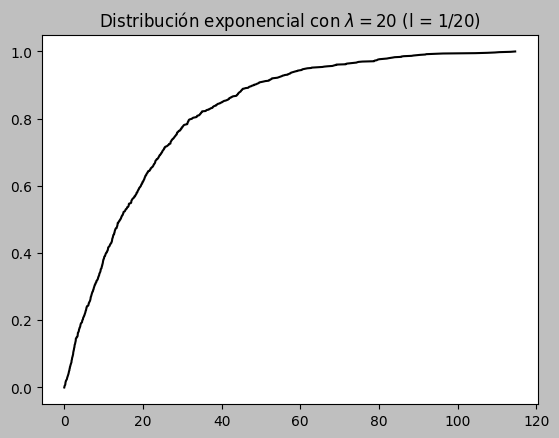

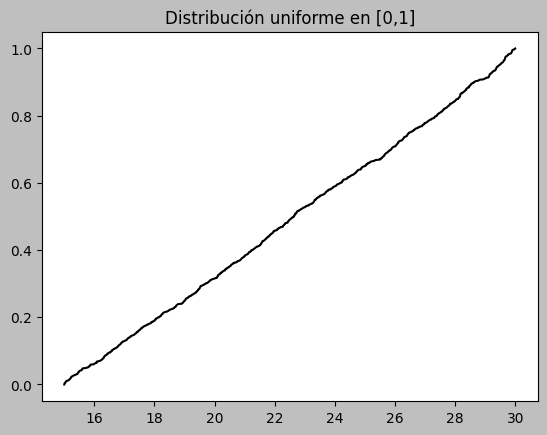

In [5]:
n = 10**3
e = gen_exp(1/20, n)
u = gen_unif(15, 30, n)

plt.style.use('grayscale')
# plt.hist(e, bins = 20)
# plt.show()
plt.plot(np.sort(e), np.linspace(0,1,n))
plt.title("Distribución exponencial con $\lambda = 20$ (l = $1/20$)")
plt.show()

# plt.hist(u)
# plt.show()
plt.plot(np.sort(u), np.linspace(0,1,n))
plt.title("Distribución uniforme en [0,1]")
plt.show()

Ahora, utilizando las funciones anteriores, se calcularán 5 números aleatorios para los calculos "manuales".

In [6]:
nc = 5 #Número de cortes que se realizarán
e = gen_exp(1/20, nc)
print("Números aleatorios con distro exponencial")
print(np.round(e, 2))

Números aleatorios con distro exponencial
[30.35  8.35  7.26 17.95  1.44]


Sin embargo, estos números aleatorios representan el tiempo entre llegadas, en otras palabras, para saber en que momento llegan se tienen que ir sumando a los tiempos anteriores, esto es:

In [7]:
tll = 0
TLL = []
for i in e:
    tll += i
    TLL.append(tll)
print(np.round(TLL,2))

[30.35 38.7  45.96 63.91 65.35]


In [8]:
u = gen_unif(15, 30, nc)
print('Números aleatorios con distro uniforme')
print(np.round(u, 2))

Números aleatorios con distro uniforme
[18.84 20.08 27.2  26.25 16.83]


A continuación se presenta una tabla con los datos anteriores. A esto hay que adicionar en que momento sale cada uno de los clientes. Para lo cual consideramos que al llegar un cliente, el peluquero puede estar ocupado con otro cliente, por lo que tendrá que esperar hasta que salga este cliente.

In [9]:
clientes = list(range(1,6))
s = [TLL[0] + u[0]]
ic = [TLL[0]]
for i in range(1, nc):
    if TLL[i] > s[i-1]: #Llegada cuando no hay gente
        s.append(TLL[i] + u[i])
    else: #LLegada cuando todavia hay gente
        s.append(s[i-1] + u[i])
    ic.append(max(s[i-1], TLL[i]))
print('Tiempos de salida\n',s)

Tiempos de salida
 [49.18559862700536, 69.26305140557616, 96.46167545913761, 122.70868459995742, 139.539955618142]


Ahora, para hacer operaciones vectoriales con los *arrays* se van a convertir las listas en *array* de la librería *Numpy*.

In [10]:
u = np.array(u) #Tiempo de corte
s = np.array(s) #Tiempo de salida
ic  =np.array(ic) #Tiempo en que inicia el corte

Además, calculamos el tiempo que espera cada cliente y el tiempo en el que permanece en la peluquería.

In [11]:
te = s-(TLL + u) #tiempo de espera
tp = s-TLL #tiempo en peluquería
# tp = u + te #Esta es una forma alternativa

Todo lo anterior se recopila en la siguiente tabla. Para ello se usará un *DataFrame* de la librería *Pandas*

In [12]:
columna = ['Tiempo de llegada', 'Tiempo de corte', 'Inicio del corte', 'Salida', 'Tiempo de espera', 'Tiempo en peluquería']
fila = []
for i in range(nc):
    fila.append(f'Cliente {i+1}')
# datos = np.transpose([TLL, u, ic, s, te, s-TLL])
datos = np.transpose([TLL, u, ic, s, te, u + te])

Tabla = pd.DataFrame(np.round(datos, 2), columns=columna, index=fila)
print(Tabla)

           Tiempo de llegada  Tiempo de corte  Inicio del corte  Salida  \
Cliente 1              30.35            18.84             30.35   49.19   
Cliente 2              38.70            20.08             49.19   69.26   
Cliente 3              45.96            27.20             69.26   96.46   
Cliente 4              63.91            26.25             96.46  122.71   
Cliente 5              65.35            16.83            122.71  139.54   

           Tiempo de espera  Tiempo en peluquería  
Cliente 1              0.00                 18.84  
Cliente 2             10.49                 30.57  
Cliente 3             23.31                 50.51  
Cliente 4             32.56                 58.80  
Cliente 5             57.36                 74.19  


Con esta información podemos calcular algunos estadísticos que nos permitan entender mejor el sistema de cola o fila.

In [13]:
long_prom_cola = sum(te)/s[-1]
t_prom_espera = sum(te)/nc
uso_prom = sum(u)/s[-1]

print(f'Longitud promedio de la cola (fila): {round(long_prom_cola, 2)} personas en cola')
print(f'Tiempo de espera promedio: {round(t_prom_espera,2)} minutos')
print(f'Uso promedio de la instalación: {round(100 * uso_prom,2)}%')

Longitud promedio de la cola (fila): 0.89 personas en cola
Tiempo de espera promedio: 24.74 minutos
Uso promedio de la instalación: 78.25%


***Simulación en Python usando Simpy***

Primero se hacen las dos funciones que simulen la peluquería y el corte de un cliente. Para ello necesitan tener ambas como entrada la variable del entorno (*env*), así como la varieble del recurso (*pelucas*).

In [14]:
def peluqueria(env, pelucas, nc, texto=True):
    global  ll, cifras, dur_corte, t_esp, fin_sim, LTLL, LC, LS

    for i in range(nc):
        #Llegada del cliente
        r = random()
        tll = -np.log(r)/ll
        yield env.timeout(tll)
        LTLL.append(env.now)
        if texto:
          print(f'----Ha llegado el cliente número {i} en el minuto {round(env.now, cifras)}----')

        env.process(corte(env, pelucas, i, texto))

Note que en la función corte se utiliza la variable de recurso (*pelucas*) para hacer una solicitud a este recurso. Esto se puede interpretar para nuestro ejemplo que el cliente pide su corte y el peluquero puede hacer dos cosas al respecto:

$\qquad*$ hacer el corte

$\qquad*$ si esta ocupado con otro cliente, decirle que espere a que termine con el corte actual.

La clave aquí es si esta ocupado o no el peluquero. Y esto es justamente lo que hacen ese par de lineas de código (*with pelucas.request() as sol:* & *yield sol*). Comprueba si esta o no ocupado el servidor.

In [15]:
def corte(env, pelucas, num, texto=True):
    global tc_min, tc_max, cifras, dur_corte, LC, LS
    a, b = tc_min, tc_max
    #Solicitud del corte
    with pelucas.request() as sol:
        yield sol

        #Inicia el corte

        #Se genera el tiempo de corte
        r = random()
        tc = a + (b-a)*r
        dur_corte += tc
        LC.append(tc)
        if texto:
          print(f'****Inicia el corte del cliente {num} en el minuto {round(env.now, cifras)}****')
        #Se suma el tiempo a la line ade tiempo actual
        yield env.timeout(tc)

        #Muestra un mensaje al término del corte
        LS.append(env.now)
        if texto:
          print(f'xxxTermina el corte del cliente {num} en el minuto {round(env.now, cifras)}xxx')
        return tc


Variables que nos servirán para modificar los diversos parámetros del problema en cuestion.

In [16]:
global tc_min, tc_max, ll, no_peluqueros, cifras
semilla = 13
seed(semilla)

no_peluqueros = 1
tc_min = 15
tc_max = 30
ll = 1/20
clientes = 5
cifras = 2

Luego las variables que nos ayudarán a recopilar la información de la limulación

In [17]:
global t_esp, dur_corte, fin_sim, LTLL, LC, LS
t_esp = 0
dur_corte = 0
fin_sim = 0

LTLL, LC, LS = [], [], []

Creamos las variables de entorno y recursos.

In [18]:
ent = simpy.Environment()
pelucas = simpy.Resource(ent, capacity=no_peluqueros)

Creamos la simulación a travéz del comando process.

In [19]:
ent.process(peluqueria(ent, pelucas, clientes))

<Process(peluqueria) object at 0x7bfa15d28340>

Y por fin, ejecutamos la simulación.

In [20]:
ent.run()

----Ha llegado el cliente número 0 en el minuto 27.02----
****Inicia el corte del cliente 0 en el minuto 27.02****
----Ha llegado el cliente número 1 en el minuto 34.58----
----Ha llegado el cliente número 2 en el minuto 37.84----
xxxTermina el corte del cliente 0 en el minuto 52.28xxx
****Inicia el corte del cliente 1 en el minuto 52.28****
xxxTermina el corte del cliente 1 en el minuto 70.74xxx
****Inicia el corte del cliente 2 en el minuto 70.74****
----Ha llegado el cliente número 3 en el minuto 71.51----
xxxTermina el corte del cliente 2 en el minuto 87.94xxx
****Inicia el corte del cliente 3 en el minuto 87.94****
----Ha llegado el cliente número 4 en el minuto 101.33----
xxxTermina el corte del cliente 3 en el minuto 113.96xxx
****Inicia el corte del cliente 4 en el minuto 113.96****
xxxTermina el corte del cliente 4 en el minuto 130.91xxx


In [21]:
LTLL, LC, LS = np.array(LTLL), np.array(LC), np.array(LS)
t_esp = sum(LS - LTLL - LC)
fin_sim = ent.now

Y finalmente presentamos los recuentos de la simulación así como sus resultados.

In [22]:
print(LTLL)
print(LC)
print(LS)
print(t_esp, dur_corte, fin_sim)

[ 27.01788863  34.57708622  37.84309064  71.51294348 101.3315631 ]
[25.26122877 18.45837913 17.20739877 26.01035403 16.95319534]
[ 52.2791174   70.73749653  87.9448953  113.95524934 130.90844468]
79.65207512522942 103.8905560518379 130.9084446773146


In [23]:
print(f'Longitud promedio de la cola (fila): {round(t_esp/fin_sim, 2)} personas en cola')
print(f'Tiempo de espera promedio: {round(t_esp/clientes,2)} minutos')
print(f'Uso promedio de la instalación: {round(100 * dur_corte/fin_sim,2)}%')

Longitud promedio de la cola (fila): 0.61 personas en cola
Tiempo de espera promedio: 15.93 minutos
Uso promedio de la instalación: 79.36%


Ahora, vamos a ir un poco más allá de lo que nos pidió el problema original y más conforme a lo que se ha visto en el curso.

Ya con el esqueleto de la peluquería, vamos a generar el experimento para ver que sucede en la peluquería con el paso de los días. Para lo cual usaremos la siguiente función.

In [24]:
def exp(n):
  global tc_min, tc_max, ll, no_peluqueros, t_esp, dur_corte, fin_sim, LTLL, LC, LS

  no_peluqueros = 1
  tc_min = 15
  tc_max = 30
  ll = 1/20
  clientes = 5
  cifras = 2

  long_cola = []
  tiempo_esp = []
  uso = []

  for _ in range(n):
    t_esp = 0
    dur_corte = 0
    fin_sim = 0

    LTLL, LC, LS = [], [], []

    ent = simpy.Environment()
    pelucas = simpy.Resource(ent, capacity=no_peluqueros)
    ent.process(peluqueria(ent, pelucas, clientes, texto=False))
    ent.run()
    LTLL, LC, LS = np.array(LTLL), np.array(LC), np.array(LS)
    t_esp = sum(LS - LTLL - LC)
    fin_sim = ent.now

    long_cola.append(t_esp/fin_sim)
    tiempo_esp.append(t_esp/clientes)
    uso.append(100 * dur_corte/fin_sim)

  return long_cola, tiempo_esp, uso

In [25]:
n = 500
a, b, c = exp(n)

In [26]:
def graf_estado(l, titulo):
  g = []
  n = len(l)
  for i in range(n):
    g.append(np.mean(l[:i+1]))
  plt.plot(g, 'lightblue')
  m = np.mean(l)
  s = np.std(l, ddof=1)
  plt.hlines(m, 0, n, color='r', linestyles='dotted')
  plt.hlines(m + 1.96*np.std(l)/np.sqrt(n), 0, n, color='g', linestyles='dashed')
  plt.hlines(m - 1.96*np.std(l)/np.sqrt(n), 0, n, color='g', linestyles='dashed')
  plt.title(titulo)
  plt.xlabel('iteraciones')
  plt.show()

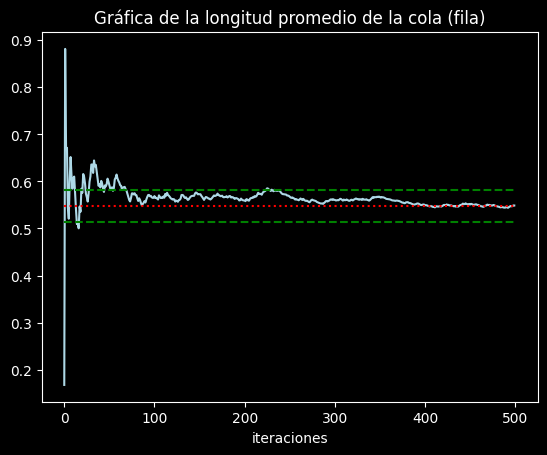

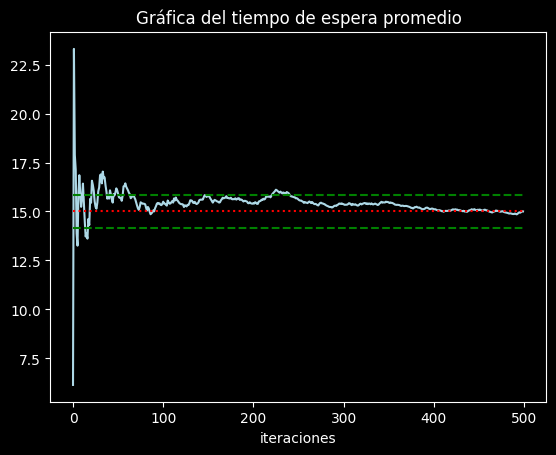

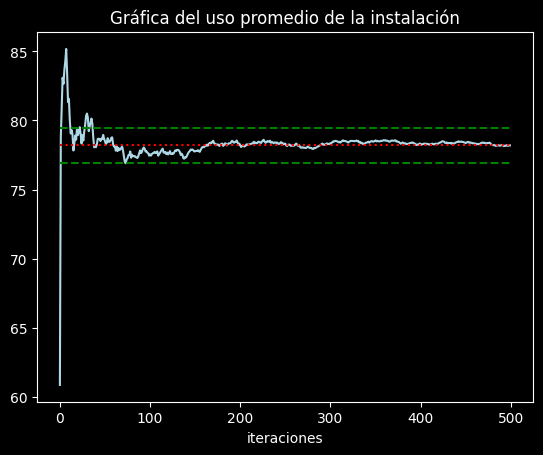

In [27]:
plt.style.use('dark_background')
graf_estado(a, 'Gráfica de la longitud promedio de la cola (fila)')
graf_estado(b, 'Gráfica del tiempo de espera promedio')
graf_estado(c, 'Gráfica del uso promedio de la instalación')

Y para rematar, hacemos la simulación multiples veces del experimento para encontrar un intervalo de confianza para cáda valor.

In [28]:
def rep(n, nr):
  la, lb, lc = [], [], []
  for _ in range(nr):
    a, b, c = exp(n)
    la.append(np.mean(a))
    lb.append(np.mean(b))
    lc.append(np.mean(c))
  return la, lb, lc

In [36]:
n = 500
nr = 100
a, b, c = rep(n, nr)

In [37]:
from scipy.stats import t
ma, mb, mc = np.mean(a), np.mean(b), np.mean(c)
sa, sb, sc = np.std(a, ddof=1), np.std(b, ddof=1), np.std(c, ddof=1)
t_student = t.ppf(0.975, nr-1)
# print(t_student)
intervalo_a = (ma - t_student*sa/np.sqrt(nr), ma + t_student*sa/np.sqrt(nr))
intervalo_b = (mb - t_student*sb/np.sqrt(nr), mb + t_student*sb/np.sqrt(nr))
intervalo_c = (mc - t_student*sc/np.sqrt(nr), mc + t_student*sc/np.sqrt(nr))
dec = 5

In [38]:
print(f'El intervalo de confianza al 95% de la longitud promedio de la cola (fila): {np.round(intervalo_a, dec)} personas en cola')
print(f'El intervalo de confianza al 95% del tiempo de espera promedio: {np.round(intervalo_b, dec)} minutos')
print(f'El intervalo de confianza al 95% del uso promedio de la instalación: {np.round(intervalo_c, dec)}%')

El intervalo de confianza al 95% de la longitud promedio de la cola (fila): [0.54456 0.55129] personas en cola
El intervalo de confianza al 95% del tiempo de espera promedio: [15.01902 15.17985] minutos
El intervalo de confianza al 95% del uso promedio de la instalación: [77.73161 77.99496]%
